cost after epoch 0: 1.855702
cost after epoch 100: 1.017255
cost after epoch 200: 0.733184
cost after epoch 300: 0.573071
cost after epoch 400: 0.468699
cost after epoch 500: 0.381208
cost after epoch 600: 0.313826
cost after epoch 700: 0.253723
cost after epoch 800: 0.203884
cost after epoch 900: 0.166440
cost after epoch 1000: 0.146653
cost after epoch 1100: 0.107271
cost after epoch 1200: 0.086613
cost after epoch 1300: 0.059327
cost after epoch 1400: 0.052237


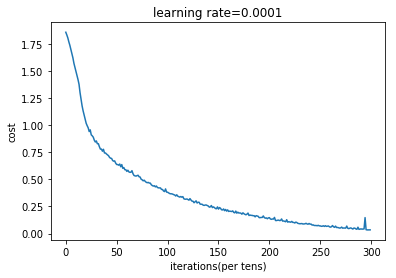

params have been trained


AttributeError: module 'tensorflow' has no attribute 'armax'

In [5]:
import math
import tensorflow as tf
import numpy as np
import h5py
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

np.random.seed(1)

def load_dataset():
    train_dataset = h5py.File('E://Project/data/tensorflow_tutorial_train_signs.h5', 'r')
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('E://Project/data/tensorflow_tutorial_test_signs.h5', 'r')
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset['list_classes'][:])

    train_set_y_orig = train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))
    return train_set_x_orig,train_set_y_orig,test_set_x_orig,test_set_y_orig,classes

def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)

    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation].reshape((Y.shape[0],m))
    num_complete_minibatches= math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batches.append((mini_batch_X,mini_batch_Y))
    if m%mini_batch_size!=0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:m]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:m]
        mini_batches.append((mini_batch_X,mini_batch_Y))
    return mini_batches

def convert_to_one_hot(Y,C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

def forward_propagation_for_predict(X, params):
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    W3 = params['W3']
    b3 = params['b3']
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    return Z3

# def relu(X):
#     return np.maximum(0,X)

# def forward_propagation_with_numpy(X, params):
#     W1 = params['W1']
#     b1 = params['b1']
#     W2 = params['W2']
#     b2 = params['b2']
#     W3 = params['W3']
#     b3 = params['b3']
#     print(W1.shape)
#     print(X.shape)
#     Z1 = np.dot(W1,X)+b1
#     print(np.dot(W1,X).shape)
#     A1 = relu(Z1)
#     Z2 = np.dot(W2,A1)+b2
#     A2 = relu(Z2)
#     Z3 = np.dot(W3,A2)+b3
#     return Z3

def predict(X, params):
    W1 = tf.convert_to_tensor(params['W1'])
    b1 = tf.convert_to_tensor(params['b1'])
    W2 = tf.convert_to_tensor(params['W2'])
    b2 = tf.convert_to_tensor(params['b2'])
    W3 = tf.convert_to_tensor(params['W3'])
    b3 = tf.convert_to_tensor(params['b3'])

    params = {'W1':W1,'b1':b1,'W2':W2,'b2':b2,'W3':W3,'b3':b3}
    x = tf.placeholder("float",[12288,1])
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})
    return prediction

def linear_function():
    np.random.seed(1)
    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.constant(np.random.randn(4,3), name = "W")
    b = tf.constant(np.random.randn(4,1), name = "b")
    Y = tf.add(tf.matmul(W,X),b)
    sess = tf.Session()
    result = sess.run(Y)
    sess.close()
    return result

def sigmoid(z):
    x = tf.placeholder(tf.float32, name="x")
    sigmoid = tf.sigmoid(x)
    with tf.Session() as sess:
        result = sess.run(sigmoid, feed_dict={x:z})
    return result

def cost(logits, labels):
    z = tf.placeholder(tf.float32,  name='z')
    y = tf.placeholder(tf.float32, name='y')
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)
    with tf.Session() as sess:
        cost = sess.run(cost, feed_dict={z:logits, y:labels})
    return cost

def one_hot_to_matrix(labels, C):
    C = tf.constant(value=C, name='C')
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

def ones(shape):
    ones = tf.ones(shape)
    sess = tf.Session()
    ones = sess.run(ones)
    sess.close()
    return ones

# flatten the dataset, then normalize it by dividing by 255, and convert each label to one-hot
def process_dataset(X_train_orig,Y_train_orig,X_test_orig,Y_test_orig):
    X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T
    X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T
    X_train = X_train_flatten/255.
    X_test = X_test_flatten/255.
    Y_train = convert_to_one_hot(Y_train_orig, 6)
    Y_test = convert_to_one_hot(Y_test_orig, 6)
    return X_train, Y_train, X_test, Y_test

def create_placeholder(n_x, n_y):
    X = tf.placeholder(tf.float32, shape=[n_x, None])
    Y = tf.placeholder(tf.float32, shape=[n_y, None])
    return X, Y

def init_params():
    """
    W1: [25,12288]
    b1: [25,1]
    W2: [12,25]
    b2: [12,1]
    W3: [6,12]
    b3: [6,1]
    """
    with tf.variable_scope("params"):
        W1 = tf.get_variable("W1", [25,12288],
                             initializer=tf.contrib.layers.xavier_initializer(seed=1))
        b1 = tf.get_variable("b1", [25,1],initializer=tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12,25],
                             initializer=tf.contrib.layers.xavier_initializer(seed=1))
        b2 = tf.get_variable("b2", [12,1],initializer=tf.zeros_initializer())
        W3 = tf.get_variable("W3", [6,12],
                             initializer=tf.contrib.layers.xavier_initializer(seed=1))
        b3 = tf.get_variable("b3", [6,1],initializer=tf.zeros_initializer())
    params = {"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
    return params

def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

def model(X_train,Y_train,X_test,Y_test,learning_rate=0.0001,
         num_epochs=1500,mini_batch_size=32,print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (n_x,m)=X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholder(n_x, n_y)
    params = init_params()
    Z3 = forward_propagation_for_predict(X, params)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m/mini_batch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train,Y_train,mini_batch_size,seed)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _,minibatch_cost = sess.run([optimizer,cost],
                                           feed_dict={X:minibatch_X,Y:minibatch_Y})
                epoch_cost+=minibatch_cost/num_minibatches
            
            if print_cost == True and epoch%100==0:
                print("cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch %5==0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations(per tens)')
        plt.title("learning rate="+str(learning_rate))
        plt.show()
        
        params = sess.run(params)
        print("params have been trained")
        
        correct_prediction = tf.equal(tf.argmax(Z3),tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        print("train accuracy: ", accuracy.eval({X:X_train,Y:Y_train}))
        print("test accuracy: ", accuracy.eval({X:X_test,Y:Y_test}))
        return params
    
if __name__ == '__main__':
    # 64*64*3 = 12288
    X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
    X_train, Y_train, X_test, Y_test = process_dataset(X_train_orig,Y_train_orig,
                                                      X_test_orig,Y_test_orig)
    params = model(X_train, Y_train, X_test, Y_test)
    
    # 检验损失函数
#     tf.reset_default_graph()

#     with tf.Session() as sess:
#         X, Y = create_placeholder(12288, 6)
#         parameters = init_params()
#         Z3 = forward_propagation_for_predict(X, parameters)
#         cost = compute_cost(Z3, Y)
#         print("cost = " + str(cost))

    
    # 显示一个图片
#     index = 0
#     plt.show(X_train_orig[index])
#     print("y="+str(np.squeeze(Y_train_orig[:,index])))
    
    # 检验初始化参数
#     tf.reset_default_graph()
#     with tf.Session() as sess:
#         params = init_params()
#         print("W1="+str(params["W1"]))

    # 检验前向传播
#     tf.reset_default_graph()
#     with tf.Session() as sess:
#         X, Y = create_placeholder(12288, 6)
#         params = init_params()
#         Z3_1 = forward_propagation_for_predict(X, params)
#         print(Z3_1)

    # 判断自己的图片
#     import scipy
#     from PIL import Image
#     from scipy import ndimage

#     my_image = "thumbs_up.jpg"

#     fname = "images/" + my_image
#     image = np.array(ndimage.imread(fname, flatten=False))
#     my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
#     my_image_prediction = predict(my_image, parameters)

#     plt.imshow(image)
#     print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))


In [8]:
import numpy as np
import tensorflow as tf

tmp = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(tmp)
a = np.transpose(tmp,[0,1])
print(a)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
